Ensure that the realistic potential I'll be using is implemented correctly.

In [1]:
from galpy.potential.mwpotentials import McMillan17 as galpy_McM17 #, MWPotential2014
from galpy.potential import plotPotentials, evaluatePotentials
from galpy.util.conversion import get_physical
import astropy.units as u
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
ro = 8 * u.kpc
vo = 220 * u.km/u.s

In [3]:
z_numpy = np.linspace(-2, 2, 100)
z_torch = torch.linspace(-2, 2, 100).to(torch.float64)

In [4]:
def comparison_plot(galpy_potential, pytorch_potential, z, title, fig=None, ax=None, c='k', label='', ncol=1):
    '''
    galpy potential should be in astropy units
    z should be a torch tensor with no units
    '''

    if fig is None or ax is None:
        fig, ax = plt.subplots(2, 1, figsize=(6, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace':0.1})
    ax[0].plot(z.numpy(), galpy_potential(z.numpy()*u.kpc), label=label+' galpy', lw=3, c=c, alpha=0.5)
    ax[0].plot(z.numpy(), pytorch_potential(z/ro.value, R=torch.tensor(1.0).to(torch.float64)), linestyle='--', c=c, lw=3, label=label+' orbitflows')
    ax[1].set_xlabel('z (kpc)')
    ax[0].set_ylabel('Potential (km^2/s^2)')

    ax[1].plot(z, galpy_potential(z*u.kpc) - pytorch_potential(z/ro.value, R=torch.tensor(1.0).to(torch.float64)).numpy(), label='Difference', lw=3, c=c)
    ax[1].set_ylabel('Difference (km^2/s^2)')

    ax[0].set_title(title)
    ax[0].legend(ncol=ncol)

    return fig, ax

# NFW

In [5]:
from galpy.potential import NFWPotential as galpy_NFW
from galpy.potential import evaluatePotentials, plotPotentials
from orbitflows import NFWPotential as pytorch_NFW

In [6]:
from orbitflows import NFW_Rforce, normalize_

In [7]:
# comparing Rforce calculation:
print(f'RForce % difference at solar radius: {100 * (galpy_NFW().Rforce(1.0, 0,0) - NFW_Rforce(torch.tensor(0.0), torch.tensor(1.0), torch.tensor(1.0), torch.tensor(1.0)).numpy())/np.mean([galpy_NFW().Rforce(1.0, 0,0), NFW_Rforce(torch.tensor(0.0), torch.tensor(1.0), torch.tensor(1.0), torch.tensor(1.0)).numpy()]):.3e} %')

RForce % difference at solar radius: -9.861e-07 %


In [8]:
# # 1D galpy NFW Potential
# galpy_NFW_1D = partial(evaluatePotentials, galpy_NFW(), 8*u.kpc)

In [9]:
galpy_NFW_1D = partial(galpy_NFW(normalize=0.35, a=2.0), 8*u.kpc)

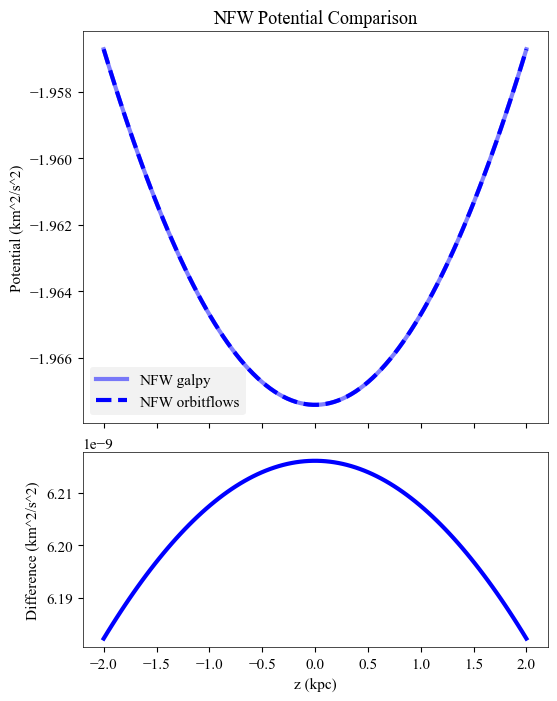

In [10]:
fig, ax = comparison_plot(galpy_NFW_1D, partial(pytorch_NFW, normalize=torch.tensor(0.35).to(torch.float64), a=torch.tensor(2.0).to(torch.float64)), z_torch, title='NFW Potential Comparison', label='NFW', c='b')

## `MiyamotoNagaiPotential`

In [11]:
from galpy.potential import MiyamotoNagaiPotential as galpy_MN
from galpy.potential import evaluatePotentials, plotPotentials
from orbitflows import MiyamotoNagaiPotential as pytorch_MN

In [12]:
galpy_MN_1D = partial(galpy_MN(a=3.0 / 8.0, b=0.28 / 8.0, normalize=0.6), 8*u.kpc)

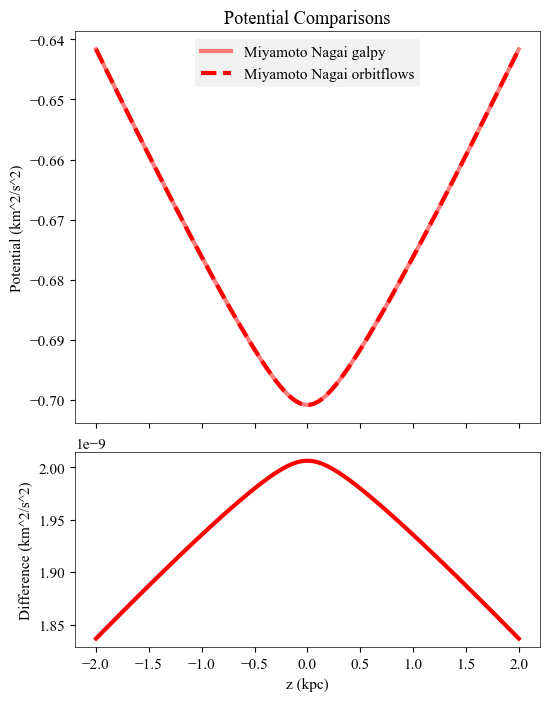

In [13]:
fig_mn, ax_mn = comparison_plot(galpy_MN_1D, partial(pytorch_MN, a=3.0 / 8.0, b=0.28 / 8.0, normalize=0.6), z_torch, title='Potential Comparisons', label='Miyamoto Nagai', c='r')

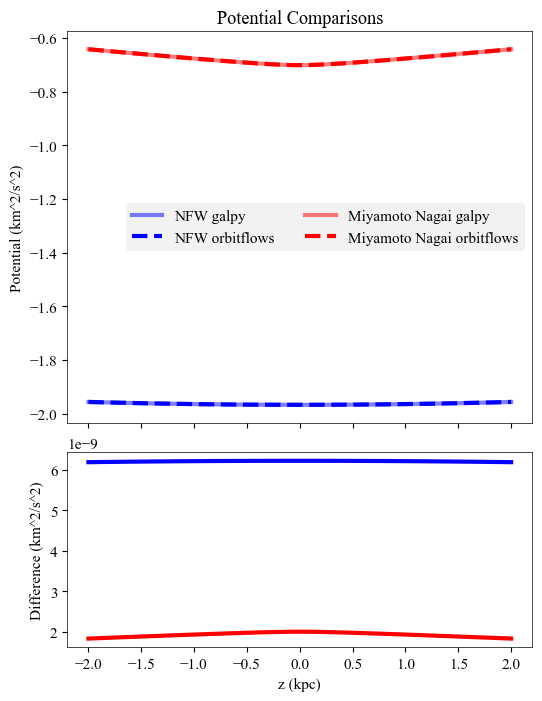

In [14]:
comparison_plot(galpy_MN_1D, partial(pytorch_MN, a=3.0 / 8.0, b=0.28 / 8.0, normalize=0.6), z_torch, title='Potential Comparisons', label='Miyamoto Nagai', fig=fig, ax=ax, c='r', ncol=2)
#comparison_plot(galpy_NFW_1D, partial(pytorch_NFW, normalize=0.35, a=2.0), z_torch, 'NFW Potential Comparison')
fig

# `PowerSphericalPotentialwCutoff`

In [15]:
from galpy.potential import PowerSphericalPotentialwCutoff as galpy_pspc
from galpy.potential import evaluatePotentials, plotPotentials
from orbitflows import PowerSphericalPotentialwCutoff as pytorch_pspc
from orbitflows import PowerSphericalwCutoff_Rforce, PowerSphericalwCutoff_mass

##

## Mass

In [16]:
galpy_pspc(normalize=0.05, alpha=1.8, rc=1.9 / 8.0)._mass(1.0)

array(1.66696688)

In [17]:
PowerSphericalwCutoff_mass(torch.tensor(1.0), alpha=torch.tensor(1.8), rc=torch.tensor(1.9/8.0))

/Users/gabrielpfaffman/Repos/orbitflows/orbitflows/utils/potentials.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R = torch.tensor(R)



tensor(1.6670)

## Rforce

In [18]:
galpy_pspc(normalize=0.05, alpha=1.8, rc=1.9 / 8.0)._Rforce(1.0, 0.5)

np.float64(-1.1927844058934143)

In [19]:
PowerSphericalwCutoff_Rforce(torch.tensor(0.5), torch.tensor(1.0), alpha=torch.tensor(1.8), rc=torch.tensor(1.9/8.0), amp=1.0)

tensor(-1.1928)

## Normalize

In [20]:
galpy_pspc(alpha=1.8, rc=1.9 / 8.0).normalize(0.05)

In [21]:
pot_ex = galpy_pspc(alpha=1.8, rc=1.9 / 8.0)
print(pot_ex._amp)
pot_ex.normalize(0.05)
print(pot_ex._amp)

1.0
0.029994597188218296


In [22]:
normalize_(0.05, partial(PowerSphericalwCutoff_Rforce, alpha=torch.tensor(1.8).to(torch.float64), rc=torch.tensor(1.9/8.0).to(torch.float64), amp=1.0))

tensor(0.0300, dtype=torch.float64)

## Potential

In [23]:
galpy_pspc_1D = partial(galpy_pspc(normalize=0.05, alpha=1.8, rc=1.9 / 8.0), 8*u.kpc)

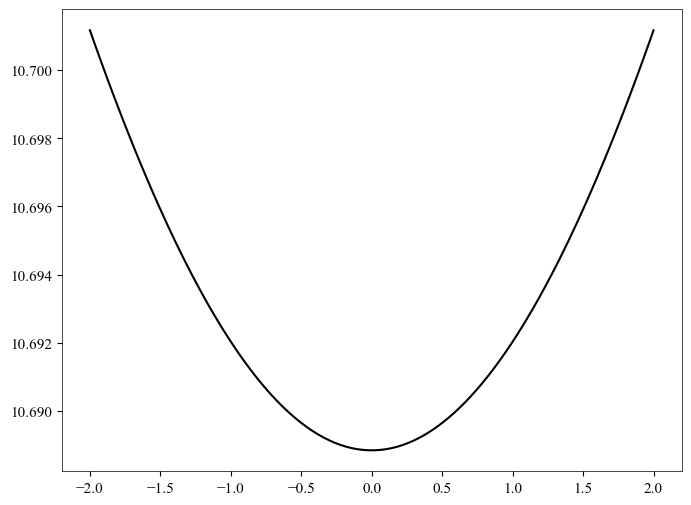

In [24]:
plt.plot(z_torch.numpy(), partial(pytorch_pspc,normalize=0.05, alpha=torch.tensor(1.8).to(torch.float64), rc=torch.tensor(1.9 / 8.0).to(torch.float64))(z_torch/ro.value, torch.tensor(1.0)).numpy())

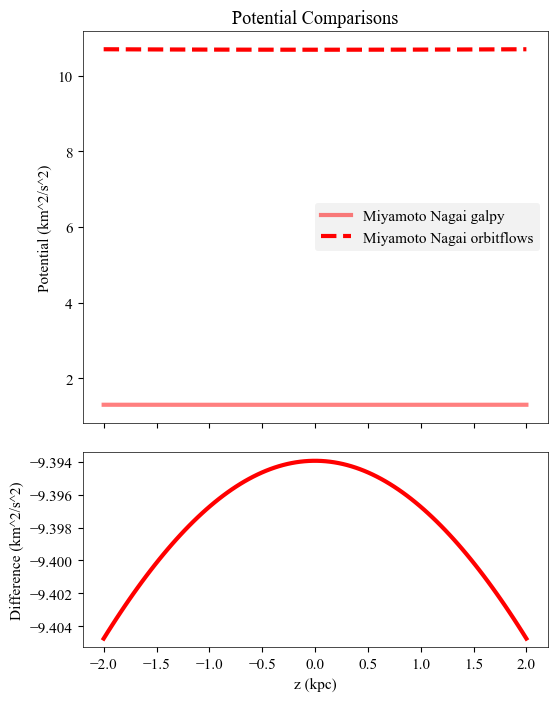

In [25]:
fig_mn, ax_mn = comparison_plot(galpy_pspc_1D, partial(pytorch_pspc,normalize=0.05, alpha=torch.tensor(1.8).to(torch.float64), rc=torch.tensor(1.9 / 8.0).to(torch.float64)), z_torch, title='Potential Comparisons', label='Miyamoto Nagai', c='r')

In [26]:
import scipy
import jax
from orbitflows import hyp1f1

In [27]:
rc = torch.tensor(1.9 / 8.0).to(torch.float64)
alpha = torch.tensor(1.8).to(torch.float64)

In [28]:
(-(z_torch/rc)**2)

tensor([-7.0914e+01, -6.8078e+01, -6.5299e+01, -6.2579e+01, -5.9916e+01,
        -5.7312e+01, -5.4765e+01, -5.2276e+01, -4.9845e+01, -4.7471e+01,
        -4.5156e+01, -4.2899e+01, -4.0699e+01, -3.8557e+01, -3.6474e+01,
        -3.4448e+01, -3.2480e+01, -3.0570e+01, -2.8717e+01, -2.6923e+01,
        -2.5186e+01, -2.3508e+01, -2.1887e+01, -2.0324e+01, -1.8819e+01,
        -1.7372e+01, -1.5983e+01, -1.4652e+01, -1.3378e+01, -1.2163e+01,
        -1.1005e+01, -9.9053e+00, -8.8634e+00, -7.8793e+00, -6.9532e+00,
        -6.0850e+00, -5.2746e+00, -4.5221e+00, -3.8275e+00, -3.1908e+00,
        -2.6120e+00, -2.0910e+00, -1.6280e+00, -1.2228e+00, -8.7548e-01,
        -5.8607e-01, -3.5453e-01, -1.8088e-01, -6.5119e-02, -7.2354e-03,
        -7.2354e-03, -6.5119e-02, -1.8088e-01, -3.5453e-01, -5.8607e-01,
        -8.7548e-01, -1.2228e+00, -1.6280e+00, -2.0910e+00, -2.6120e+00,
        -3.1908e+00, -3.8275e+00, -4.5221e+00, -5.2746e+00, -6.0850e+00,
        -6.9532e+00, -7.8793e+00, -8.8634e+00, -9.9

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_99604/1399173650.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(z_numpy, scipy.special.hyp1f1(0.6,1.6,-(z_numpy/rc)**2) - hyp1f1(torch.tensor(0.6).to(torch.float64),torch.tensor(1.6).to(torch.float64),(-(z_torch.to(torch.float32)/rc)**2)).numpy()) #jax.scipy.special.hyp1f1(z_numpy*8,1,-1)), hyp1f1(z_torch*8,torch.tensor(2).to(torch.float64),torch.tensor(-1).to(torch.float64))



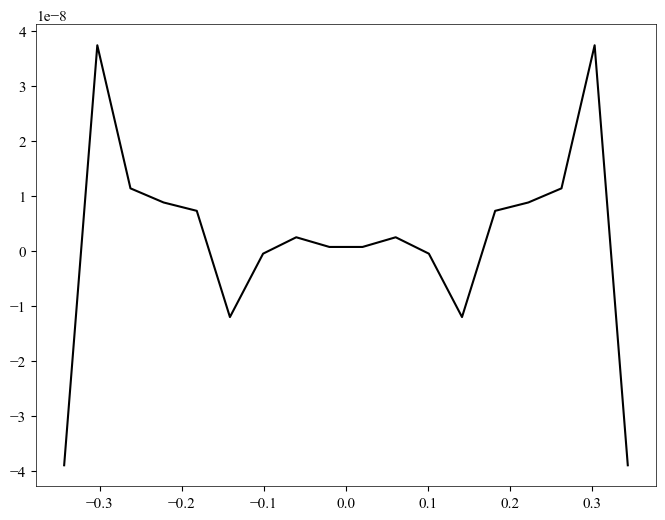

In [29]:
plt.plot(z_numpy, scipy.special.hyp1f1(0.6,1.6,-(z_numpy/rc)**2) - hyp1f1(torch.tensor(0.6).to(torch.float64),torch.tensor(1.6).to(torch.float64),(-(z_torch.to(torch.float32)/rc)**2)).numpy()) #jax.scipy.special.hyp1f1(z_numpy*8,1,-1)), hyp1f1(z_torch*8,torch.tensor(2).to(torch.float64),torch.tensor(-1).to(torch.float64))

In [30]:
scipy.special.hyp1f1(0.6,1.6,-(z_numpy/rc)**2) - hyp1f1(torch.tensor(0.6).to(torch.float64),torch.tensor(1.6).to(torch.float64),(-(z_torch.to(torch.float64)/rc)**2)).numpy()

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_99604/1423581497.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  scipy.special.hyp1f1(0.6,1.6,-(z_numpy/rc)**2) - hyp1f1(torch.tensor(0.6).to(torch.float64),torch.tensor(1.6).to(torch.float64),(-(z_torch.to(torch.float64)/rc)**2)).numpy()



tensor([-3.2975e+22, -8.1181e+21, -1.9403e+21, -4.4965e+20, -1.0090e+20,
        -2.1892e+19, -4.5853e+18, -9.2565e+17, -1.7978e+17, -3.3529e+16,
        -5.9924e+15, -1.0240e+15, -1.6693e+14, -2.5892e+13, -3.8103e+12,
        -5.3042e+11, -6.9618e+10, -8.5840e+09, -9.9045e+08, -1.0648e+08,
        -1.0616e+07, -9.7634e+05, -8.2357e+04, -6.3302e+03, -4.4003e+02,
        -2.7385e+01, -1.4931e+00, -6.4355e-02, -9.3055e-05,  7.6659e-04,
         2.2642e-04,  4.8218e-05,  4.1669e-06, -3.2777e-06, -2.7809e-06,
        -1.4597e-06, -6.1937e-07, -2.5788e-07, -8.2288e-08, -3.3360e-09,
         3.8463e-09, -6.7620e-09,  2.2744e-08,  3.6571e-09,  8.8740e-09,
         1.3647e-08, -5.7863e-09, -7.7925e-10,  1.9903e-09,  5.6028e-10,
         5.6028e-10,  1.9903e-09, -7.7925e-10, -5.7863e-09,  1.3647e-08,
         8.8740e-09,  3.6571e-09,  2.2744e-08, -6.7620e-09,  3.8463e-09,
        -3.3360e-09, -8.2288e-08, -2.5788e-07, -6.1937e-07, -1.4597e-06,
        -2.7809e-06, -3.2777e-06,  4.1669e-06,  4.8

In [31]:
hyp1f1(torch.tensor(0.6).to(torch.float64),torch.tensor(1.6).to(torch.float64),(-(z_torch.to(torch.float64)/rc)**2)).numpy()

array([3.29750899e+22, 8.11808934e+21, 1.94030530e+21, 4.49653582e+20,
       1.00899811e+20, 2.18917364e+19, 4.58534407e+18, 9.25653828e+17,
       1.79780247e+17, 3.35290246e+16, 5.99236692e+15, 1.02404498e+15,
       1.66934039e+14, 2.58917219e+13, 3.81029974e+12, 5.30420576e+11,
       6.96176694e+10, 8.58402968e+09, 9.90448671e+08, 1.06481383e+08,
       1.06157994e+07, 9.76338471e+05, 8.23570616e+04, 6.33039630e+03,
       4.40187535e+02, 2.75460050e+01, 1.66252925e+00, 2.42826417e-01,
       1.88571758e-01, 1.98797972e-01, 2.11680563e-01, 2.25675351e-01,
       2.41278639e-01, 2.58920913e-01, 2.79044082e-01, 3.02164978e-01,
       3.28902935e-01, 3.59982959e-01, 3.96208184e-01, 4.38386275e-01,
       4.87191272e-01, 5.42951949e-01, 6.05378075e-01, 6.73268260e-01,
       7.44277794e-01, 8.14849049e-01, 8.80396053e-01, 9.35784710e-01,
       9.76062239e-01, 9.97292755e-01, 9.97292755e-01, 9.76062239e-01,
       9.35784710e-01, 8.80396053e-01, 8.14849049e-01, 7.44277794e-01,
      

In [32]:
torch.tensor(0.6).to(torch.float64),torch.tensor(1.6).to(torch.float64),(-(z_torch[-1].to(torch.float32)/rc)**2)

(tensor(0.6000, dtype=torch.float64),
 tensor(1.6000, dtype=torch.float64),
 tensor(-70.9141, dtype=torch.float64))

In [33]:
scipy.special.hyp1f1(0.6,1.6,-(z_numpy/rc)**2)

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_99604/811158563.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  scipy.special.hyp1f1(0.6,1.6,-(z_numpy/rc)**2)



tensor([0.0693, 0.0710, 0.0728, 0.0747, 0.0767, 0.0787, 0.0809, 0.0832, 0.0856,
        0.0882, 0.0908, 0.0937, 0.0967, 0.0999, 0.1033, 0.1069, 0.1107, 0.1148,
        0.1192, 0.1239, 0.1289, 0.1344, 0.1403, 0.1467, 0.1536, 0.1611, 0.1694,
        0.1785, 0.1885, 0.1996, 0.2119, 0.2257, 0.2413, 0.2589, 0.2790, 0.3022,
        0.3289, 0.3600, 0.3962, 0.4384, 0.4872, 0.5430, 0.6054, 0.6733, 0.7443,
        0.8148, 0.8804, 0.9358, 0.9761, 0.9973, 0.9973, 0.9761, 0.9358, 0.8804,
        0.8148, 0.7443, 0.6733, 0.6054, 0.5430, 0.4872, 0.4384, 0.3962, 0.3600,
        0.3289, 0.3022, 0.2790, 0.2589, 0.2413, 0.2257, 0.2119, 0.1996, 0.1885,
        0.1785, 0.1694, 0.1611, 0.1536, 0.1467, 0.1403, 0.1344, 0.1289, 0.1239,
        0.1192, 0.1148, 0.1107, 0.1069, 0.1033, 0.0999, 0.0967, 0.0937, 0.0908,
        0.0882, 0.0856, 0.0832, 0.0809, 0.0787, 0.0767, 0.0747, 0.0728, 0.0710,
        0.0693], dtype=torch.float64)

In [34]:
-(z_torch/rc)**2

tensor([-7.0914e+01, -6.8078e+01, -6.5299e+01, -6.2579e+01, -5.9916e+01,
        -5.7312e+01, -5.4765e+01, -5.2276e+01, -4.9845e+01, -4.7471e+01,
        -4.5156e+01, -4.2899e+01, -4.0699e+01, -3.8557e+01, -3.6474e+01,
        -3.4448e+01, -3.2480e+01, -3.0570e+01, -2.8717e+01, -2.6923e+01,
        -2.5186e+01, -2.3508e+01, -2.1887e+01, -2.0324e+01, -1.8819e+01,
        -1.7372e+01, -1.5983e+01, -1.4652e+01, -1.3378e+01, -1.2163e+01,
        -1.1005e+01, -9.9053e+00, -8.8634e+00, -7.8793e+00, -6.9532e+00,
        -6.0850e+00, -5.2746e+00, -4.5221e+00, -3.8275e+00, -3.1908e+00,
        -2.6120e+00, -2.0910e+00, -1.6280e+00, -1.2228e+00, -8.7548e-01,
        -5.8607e-01, -3.5453e-01, -1.8088e-01, -6.5119e-02, -7.2354e-03,
        -7.2354e-03, -6.5119e-02, -1.8088e-01, -3.5453e-01, -5.8607e-01,
        -8.7548e-01, -1.2228e+00, -1.6280e+00, -2.0910e+00, -2.6120e+00,
        -3.1908e+00, -3.8275e+00, -4.5221e+00, -5.2746e+00, -6.0850e+00,
        -6.9532e+00, -7.8793e+00, -8.8634e+00, -9.9

In [35]:
hyp1f1(torch.tensor(1).to(torch.float64),torch.tensor(2).to(torch.float64),torch.tensor(-17).to(torch.float64))

tensor(21.3099, dtype=torch.float64)

In [36]:
scipy.special.hyp1f1(1.5 - alpha / 2.0,
            2.5 - alpha / 2.0,
            -((1 / rc) ** 2.0))

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_99604/1126480494.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  scipy.special.hyp1f1(1.5 - alpha / 2.0,



tensor(0.1592, dtype=torch.float64)

In [37]:
torch.tensor(1.5 - alpha / 2.0).to(torch.float64), torch.tensor(2.5 - alpha / 2.0).to(torch.float64), torch.tensor(-((torch.tensor(1) / rc) ** 2.0).to(torch.float32))

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_99604/924620238.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(1.5 - alpha / 2.0).to(torch.float64), torch.tensor(2.5 - alpha / 2.0).to(torch.float64), torch.tensor(-((torch.tensor(1) / rc) ** 2.0).to(torch.float32))



(tensor(0.6000, dtype=torch.float64),
 tensor(1.6000, dtype=torch.float64),
 tensor(-17.7285))

In [38]:
hyp1f1(torch.tensor(1.5 - alpha / 2.0).to(torch.float64),
            torch.tensor(2.5 - alpha / 2.0).to(torch.float64),
            torch.tensor(-((torch.tensor(1) / rc) ** 2.0)).to(torch.float32),)

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_99604/1997848266.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hyp1f1(torch.tensor(1.5 - alpha / 2.0).to(torch.float64),

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_99604/1997848266.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(2.5 - alpha / 2.0).to(torch.float64),

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_99604/1997848266.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(-((torch.tensor(1) / rc) ** 2.0)).to

tensor(nan, dtype=torch.float64)

In [39]:
from galpy.potential import SCFPotential, DiskSCFPotential

In [40]:
torch.special.gammaln(torch.tensor(10)).exp(), np.exp(scipy.special.gammaln(10)), scipy.special.gamma(10)

(tensor(362880.), np.float64(362879.9999999998), np.float64(362880.0))

# `MWPotential2014`

In [41]:
from galpy.potential import MWPotential2014 as galpy_MW14
from orbitflows import MWPotential2014 as pytorch_MW14

In [42]:
galpy_MW14_1D = partial(evaluatePotentials, galpy_MW14, ro)
pytorch_MW14_1D = partial(pytorch_MW14, R=1.0)

In [43]:
partial(evaluatePotentials,galpy_MW14, 8)

functools.partial(<function evaluatePotentials at 0x177687560>, [<galpy.potential.PowerSphericalPotentialwCutoff.PowerSphericalPotentialwCutoff object at 0x1777aef90>, <galpy.potential.MiyamotoNagaiPotential.MiyamotoNagaiPotential object at 0x1777aef60>, <galpy.potential.TwoPowerSphericalPotential.NFWPotential object at 0x1777af020>], 8)

In [44]:
galpy_MW14_1D(0.0)

np.float64(-1.3733506513947897)

In [45]:
galpy_MW14[0](1.0, 0)

np.float64(1.2949195264478763)

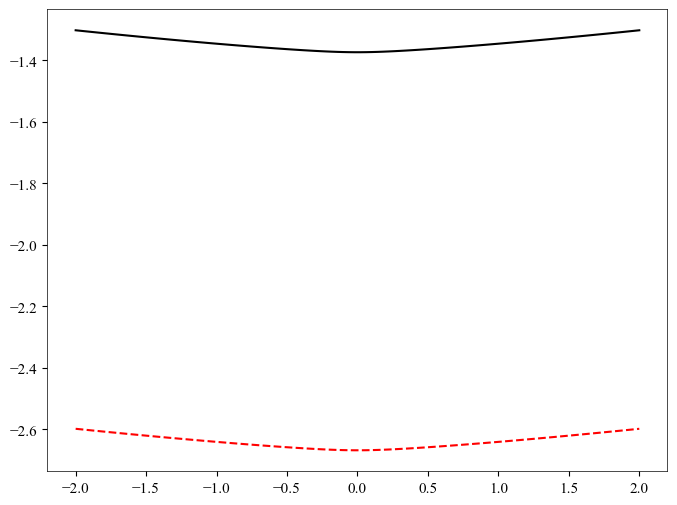

In [46]:
plt.plot(z_numpy, galpy_MW14_1D(z_numpy*u.kpc), label='galpy MW14')
plt.plot(z_numpy, pytorch_MW14_1D(z_torch/ro.value, R=torch.tensor(1.0).to(torch.float64)).numpy(), linestyle='--', label='pytorch MW14', c='r')

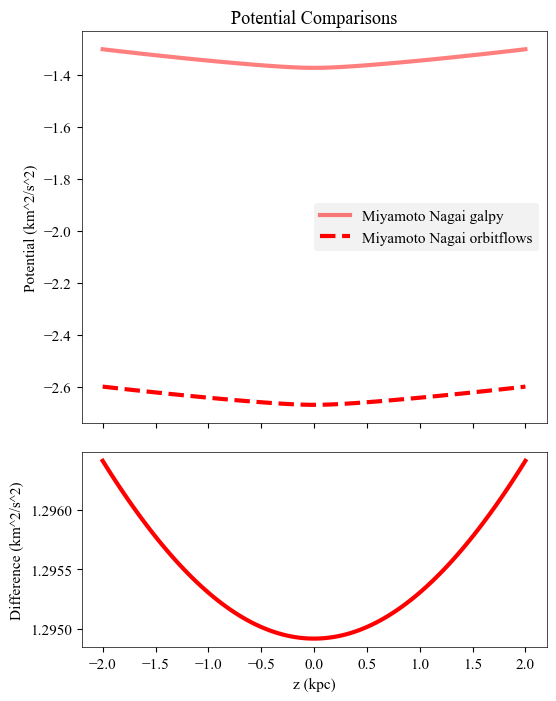

In [47]:
fig_mw, ax_mw = comparison_plot(galpy_MW14_1D, pytorch_MW14, z_torch, title='Potential Comparisons', label='Miyamoto Nagai', c='r')

this is good enough for now, since it really only varies by a constant, more or les

## galpy `galpy_McM17` Potential

In [48]:
r0 = get_physical(galpy_McM17)['ro']

In [49]:
galpy_pot = galpy_McM17
galpy_1D_McM = partial(evaluatePotentials, galpy_McM17, 1.0)

Text(0, 0.5, 'Difference (km^2/s^2)')

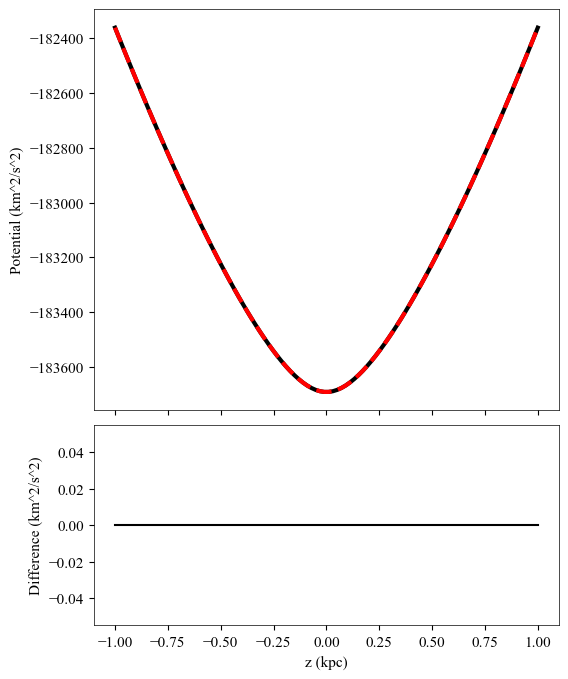

In [50]:
zlist = np.linspace(-1, 1, 100)
fig, ax = plt.subplots(2, 1, figsize=(6, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace':0.05})
ax[0].plot(zlist, galpy_1D_McM(zlist/r0), lw=3, label='unitless galpy_McM17')
ax[0].plot(zlist, evaluatePotentials(galpy_McM17, r0*u.kpc, zlist*u.kpc), c='r', linestyle='--', lw=3, label='galpy_McM17 w/ units')

ax[0].set_ylabel('Potential (km^2/s^2)')

ax[1].plot(zlist, galpy_1D_McM(zlist/8.21) - evaluatePotentials(galpy_McM17, 8.21*u.kpc, zlist*u.kpc))
ax[1].set_xlabel('z (kpc)')
ax[1].set_ylabel('Difference (km^2/s^2)')

## pytorch implementation

In [51]:
from orbitflows import McMillan17 as pytorch_McM17

ImportError: cannot import name 'McMillan17' from 'orbitflows' (/Users/gabrielpfaffman/Repos/orbitflows/orbitflows/__init__.py)